## Atlas-level integration and label transfer
An important task of single-cell analysis is the integration of several datasets. scVI can be used for this purpose. We can also use scANVI, an end-to-end framework for transfer of annotations. Here we demonstrate this functionality with an integrated analysis of cells from Tabula Muris. The same pipeline would generally be used to analyze a collection of scRNA-seq datasets.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi-tutorials/blob/dev/harmonization.ipynb)


In [ ]:
import sys

#if True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules


if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]


     |████████████████████████████████| 61kB 3.1MB/s 
ERROR: nbclient 0.5.0 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
  Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0
  Cloning https://github.com/yoseflab/scvi-tools (to revision master) to /tmp/pip-install-5chsu8ye/scvi-tools
  Running command git clone -q https://github.com/yoseflab/scvi-tools /tmp/pip-install-5chsu8ye/scvi-tools
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 122kB 4.9MB/s 
     |████████████████████████████████| 153kB 14.6MB/s 
     |████████████████████████████████| 112kB 15.6MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 2.4MB 15.1MB/s 
     |███████

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scvi

sc.set_figure_params(figsize=(4, 4))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dataset1 = sc.read(
    "data/TM_droplet.h5ad",
    backup_url="https://s3.amazonaws.com/czbiohub-tabula-muris/TM_droplet_mat.h5ad",
)
dataset2 = sc.read(
    "data/TM_facs.h5ad",
    backup_url="https://s3.amazonaws.com/czbiohub-tabula-muris/TM_facs_mat.h5ad",
)
dataset1.obs = pd.read_csv(
    "https://github.com/czbiohub/tabula-muris-vignettes/raw/master/data/TM_droplet_metadata.csv"
)
dataset2.obs = pd.read_csv(
    "https://github.com/czbiohub/tabula-muris-vignettes/raw/master/data/TM_facs_metadata.csv",
)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We subset to labelled bone marrow cells because it is a reasonably sized dataset that will allow us to validate our method's ability to transfer labels from one dataset to another.

In [ ]:
dataset1 = dataset1[
    (dataset1.obs.tissue == "Marrow") & (~dataset1.obs.cell_ontology_class.isna())
].copy()
dataset2 = dataset2[
    (dataset2.obs.tissue == "Marrow") & (~dataset2.obs.cell_ontology_class.isna())
].copy()

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
dataset1.shape, dataset2.shape

((3652, 23433), (5037, 23433))

## Dataset preprocessing

### Normalize Smartse2 matrix by gene length

We apply gene-length normalization because the number of reads representing a transcript is proportional to the lenght of the transcript, unless UMIs are used. A discussion of this phenomenon can be found in this 2017 [paper](https://europepmc.org/article/med/28529717) by Phipson B. 
Other than the gene length normalization, no other normalization is needed. scVI or scANVI is designed to handle sequencing depth and does not need cell-wise normalization. Normalizing and scaling the data will be detrimental to the performance of scVI and scANVI since they model explicitly the count data. 

The gene length file here is computed by taking the average length of alal transcripts corresponding to a mouse gene recorded in the ensembl dataabase. 

In [ ]:
gene_len = pd.read_csv(
    "https://raw.githubusercontent.com/chenlingantelope/HarmonizationSCANVI/master/data/gene_len.txt",
    delimiter=" ",
    header=None,
    index_col=0,
)
gene_len.head()

,1
0,
0610007C21Rik,94.571429
0610007L01Rik,156.000000
0610007P08Rik,202.272727
0610007P14Rik,104.000000
0610007P22Rik,158.750000


In [ ]:
gene_len = gene_len.reindex(dataset2.var.index).dropna()
dataset2 = dataset2[:, gene_len.index]
assert (dataset2.var.index == gene_len.index).sum() == dataset2.shape[1]
dataset2.X = dataset2.X / gene_len[1].values * np.median(gene_len[1].values)
# round to integer
dataset2.X = np.rint(dataset2.X)

### Dataset concatenation and gene selection
Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate for large gene sets in terms of runtime, we usually recommend filtering genes for best performance when the dataset has few number of cells. As a rule of thumb, performance starts to decrease when number of cells and number of genes are comparable. This point is emphasized in this [comparative analysis](https://doi.org/10.1101/2020.05.22.111161) of data integration algorithms for scRNA-seq data.

We perform this gene selection using the Scanpy pipeline while keeping the raw data in the adata.raw object. We obtain variable genes from each dataset and take their intersections. 

In [ ]:
adata = dataset1.concatenate(dataset2)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata, 
    flavor="seurat_v3", 
    n_top_genes=2000, 
    layer="counts", 
    batch_key="batch",
    subset=True
)

## Integration with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

* Register the AnnData object with the correct key to identify the sample.
* Create an SCVI model object.

In [ ]:
scvi.data.setup_anndata(adata, layer="counts", batch_key="batch")

INFO      Using batches from adata.obs["batch"]                                 
INFO      No label_key inputted, assuming all cells have same label             
INFO      Using data from adata.layers["counts"]                                
INFO      Computing library size prior per batch                                
INFO      Successfully registered anndata object containing 8689 cells, 2000    
          genes, 2 batches, 1 labels, and 0 proteins. Also registered 0 extra   
          categorical covariates and 0 extra continuous covariates.             
INFO      Please do not further modify adata until model is trained.            


In [ ]:
vae = scvi.model.SCVI(adata)

Now we train scVI. This should take a couple of minutes on a Colab session

In [ ]:
vae.train()

INFO      Training time:  246 s. / 400 epochs                                   


Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [ ]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

Finally, we can cluster the dataset and visualize it with UMAP

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

... storing 'channel' as categorical
... storing 'mouse.id' as categorical
... storing 'tissue' as categorical
... storing 'subtissue' as categorical
... storing 'mouse.sex' as categorical
... storing 'method' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'plate.barcode' as categorical
... storing 'FACS.selection' as categorical


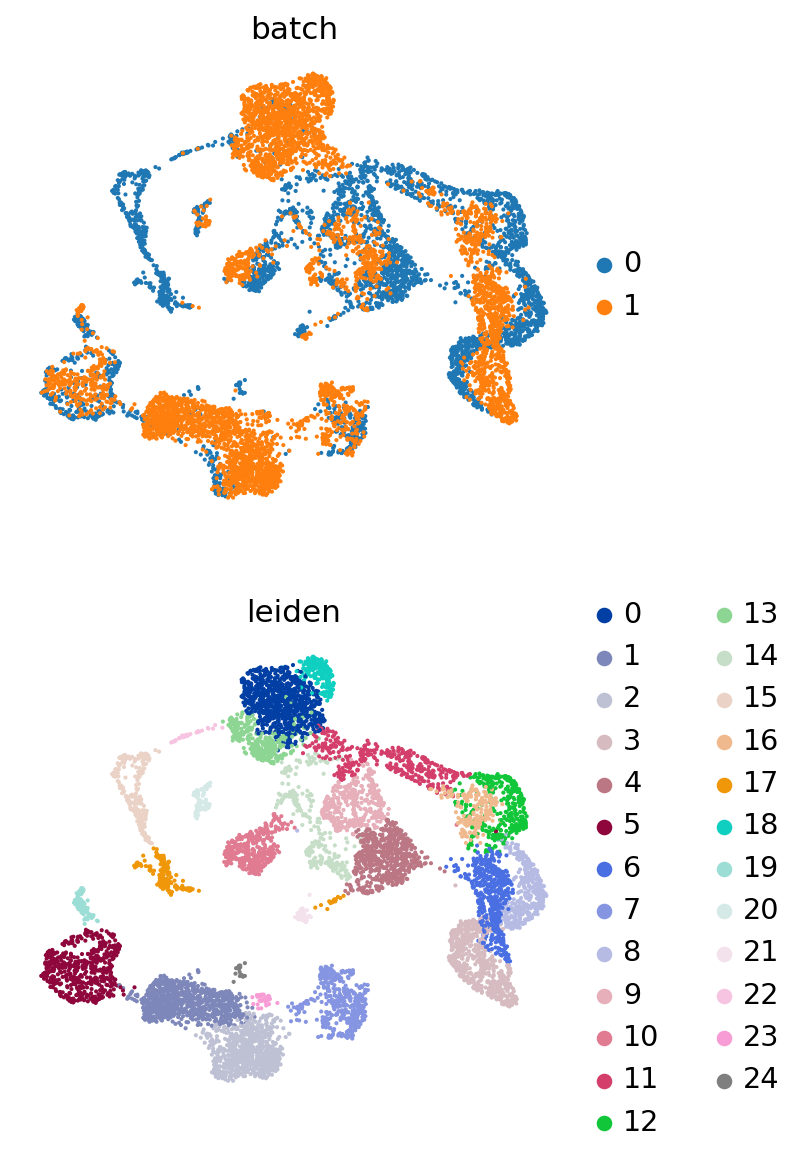

In [ ]:
sc.pl.umap(
    adata, 
    color=["batch", "leiden"], 
    frameon=False, 
    ncols=1, 
)

Because this combination of datasets is used for benchmarking purposes, we have access here to curated annotations. We can use those to assess whether the harmonization worked reasonably well. 

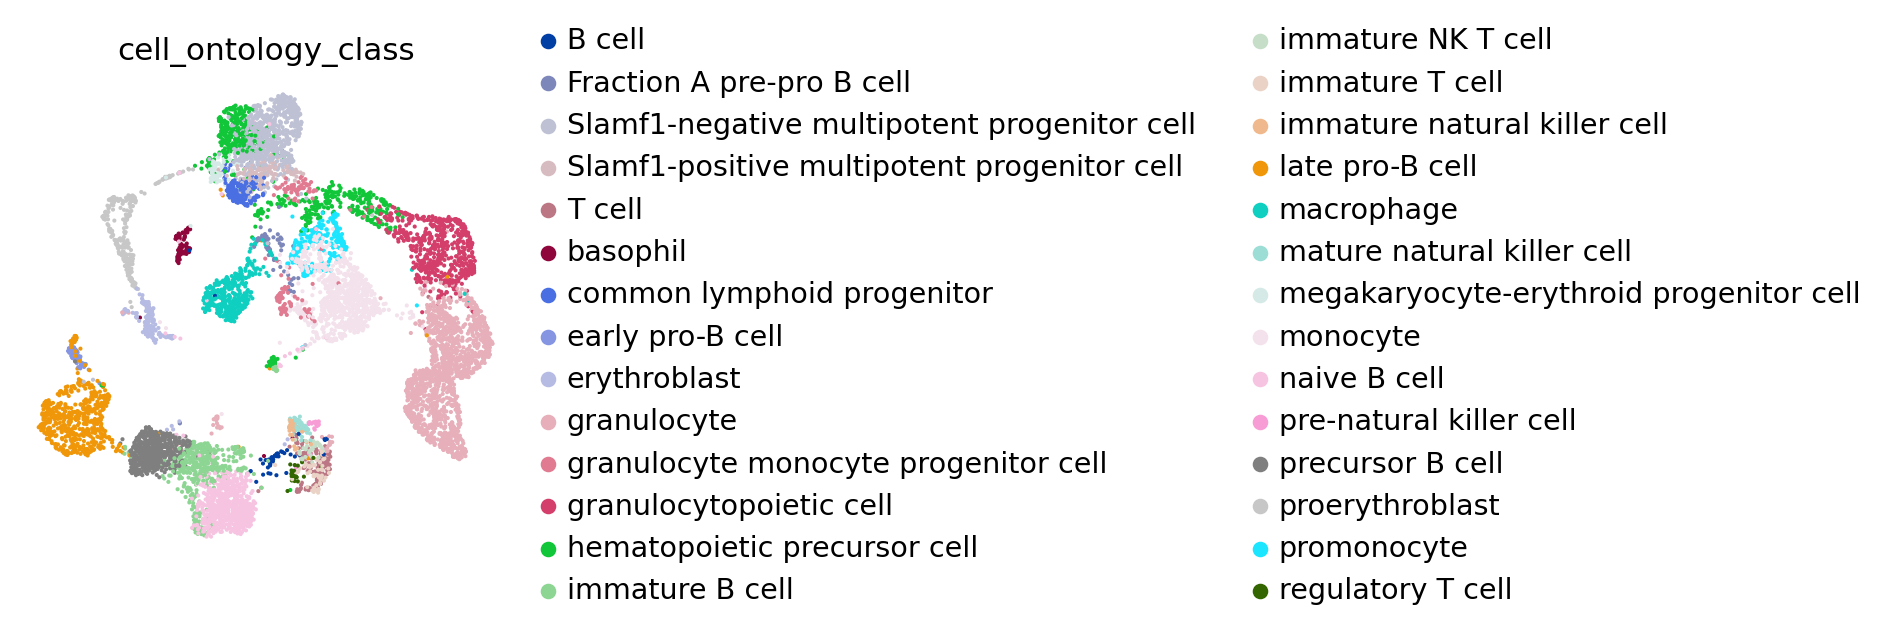

In [ ]:
sc.pl.umap(adata, color="cell_ontology_class", frameon=False)

From a quick glance, it looks like the integration worked well. Indeed, the two datasets are relatively mixed in latent space and the cell types cluster together. A more refined analysis may be done at the level of markers.

## Transfer of annotations with scANVI

We now investigate a different although complementary problem. Previously, we used scVI as we assumed we did not have any cell type annotation available to guide us. Consequently, one would need to use marker genes in order to annotate the clusters from the previous analysis. 

Now, we assume that one dataset plays the role of the reference data, with known labels, and one is the query. We will use scANVI to transfer our cell type knowledge from the reference to the query data. For this, we simply need to indicate to indicate to scANVI:

* the sample identifier for each cell (as in scVI)
* the cell type, or an unnassigned label for each cell


#### scANVI labels

<div class="alert alert-info">

Note

We assume that the Smartseq2 data is annotated and the 10X data is not. We then subsample the labels so that each cell type is more or less equally represented by setting a maximum number of labelled cells per cell type (here set to 100). Only the labels of the subsetted cells from the labelled Smartseq2 dataset will be kept in the adata.obs column 'celltype_scanvi'. All other cells will have 'celltype_scanvi' of value 'Unknown'. 

</div>

In [ ]:
labels = np.repeat("Unknown", adata.shape[0])
labels = labels.astype("<U43")
for x in np.unique(adata.obs.cell_ontology_class):
    idx = np.where((adata.obs.cell_ontology_class == x) & (adata.obs["batch"] == "1"))[
        0
    ]
    sampled = np.random.choice(idx, np.min([100, len(idx)]))
    labels[sampled] = adata.obs.cell_ontology_class[sampled]

adata.obs["celltype_scanvi"] = labels

In [ ]:
np.unique(adata.obs["celltype_scanvi"])

array(['B cell', 'Slamf1-negative multipotent progenitor cell',
       'Slamf1-positive multipotent progenitor cell', 'Unknown',
       'basophil', 'common lymphoid progenitor', 'granulocyte',
       'granulocyte monocyte progenitor cell', 'granulocytopoietic cell',
       'hematopoietic precursor cell', 'immature B cell',
       'immature NK T cell', 'immature T cell',
       'immature natural killer cell', 'late pro-B cell', 'macrophage',
       'mature natural killer cell',
       'megakaryocyte-erythroid progenitor cell', 'monocyte',
       'naive B cell', 'pre-natural killer cell', 'precursor B cell',
       'regulatory T cell'], dtype=object)

Now we may register the AnnData object and run scANVI.

In [ ]:
scvi.data.setup_anndata(
    adata, 
    layer="counts",
    batch_key="batch", 
    labels_key="celltype_scanvi", 
)

INFO      Using batches from adata.obs["batch"]                                 
INFO      Using labels from adata.obs["celltype_scanvi"]                        
INFO      Using data from adata.layers["counts"]                                
INFO      Computing library size prior per batch                                
INFO      Successfully registered anndata object containing 8689 cells, 2000    
          genes, 2 batches, 23 labels, and 0 proteins. Also registered 0 extra  
          categorical covariates and 0 extra continuous covariates.             
INFO      Please do not further modify adata until model is trained.            


In [ ]:
lvae = scvi.model.SCANVI(adata, "Unknown", use_cuda=True, n_latent=30, n_layers=2)

In [ ]:
lvae.train(n_epochs_semisupervised=100)

INFO      Training is still in warming up phase. If your applications rely on   
          the posterior quality, consider training for more epochs or reducing  
          the kl warmup.                                                        
INFO      Training time:  172 s. / 100 epochs                                   


Now we can predict the missing cell types, and get the latent space

In [ ]:
adata.obs["C_scANVI"] = lvae.predict(adata)
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

Again, we may visualize the latent space as well as the inferred labels

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

... storing 'celltype_scanvi' as categorical
... storing 'C_scANVI' as categorical


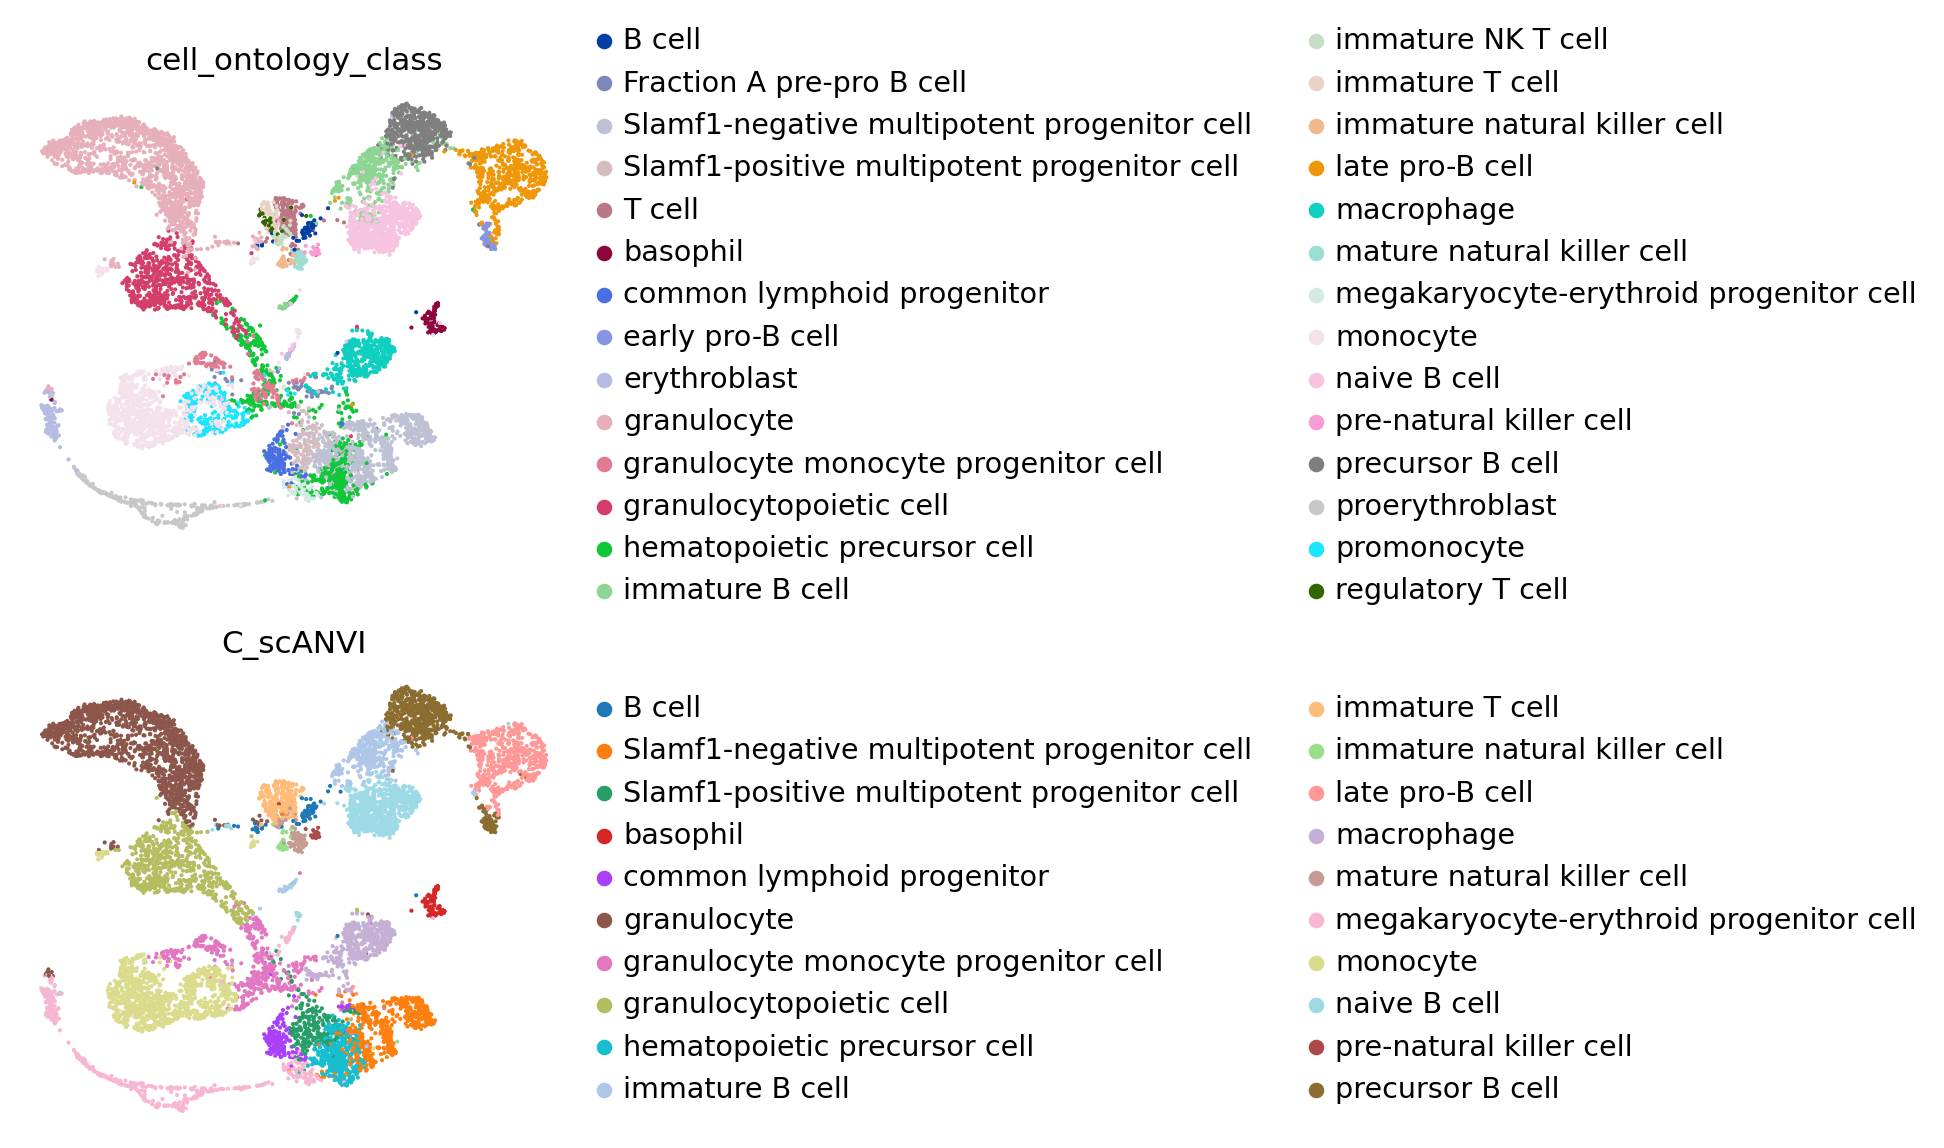

In [ ]:
sc.pl.umap(adata, color=["cell_ontology_class", "C_scANVI"], ncols=1, frameon=False)

Now we can observe scANVI's performance using a confusion matrix.

In [ ]:
df = adata.obs.groupby(["cell_ontology_class", "C_scANVI"]).size().unstack(fill_value=0)

Text(0, 0.5, 'Observed')

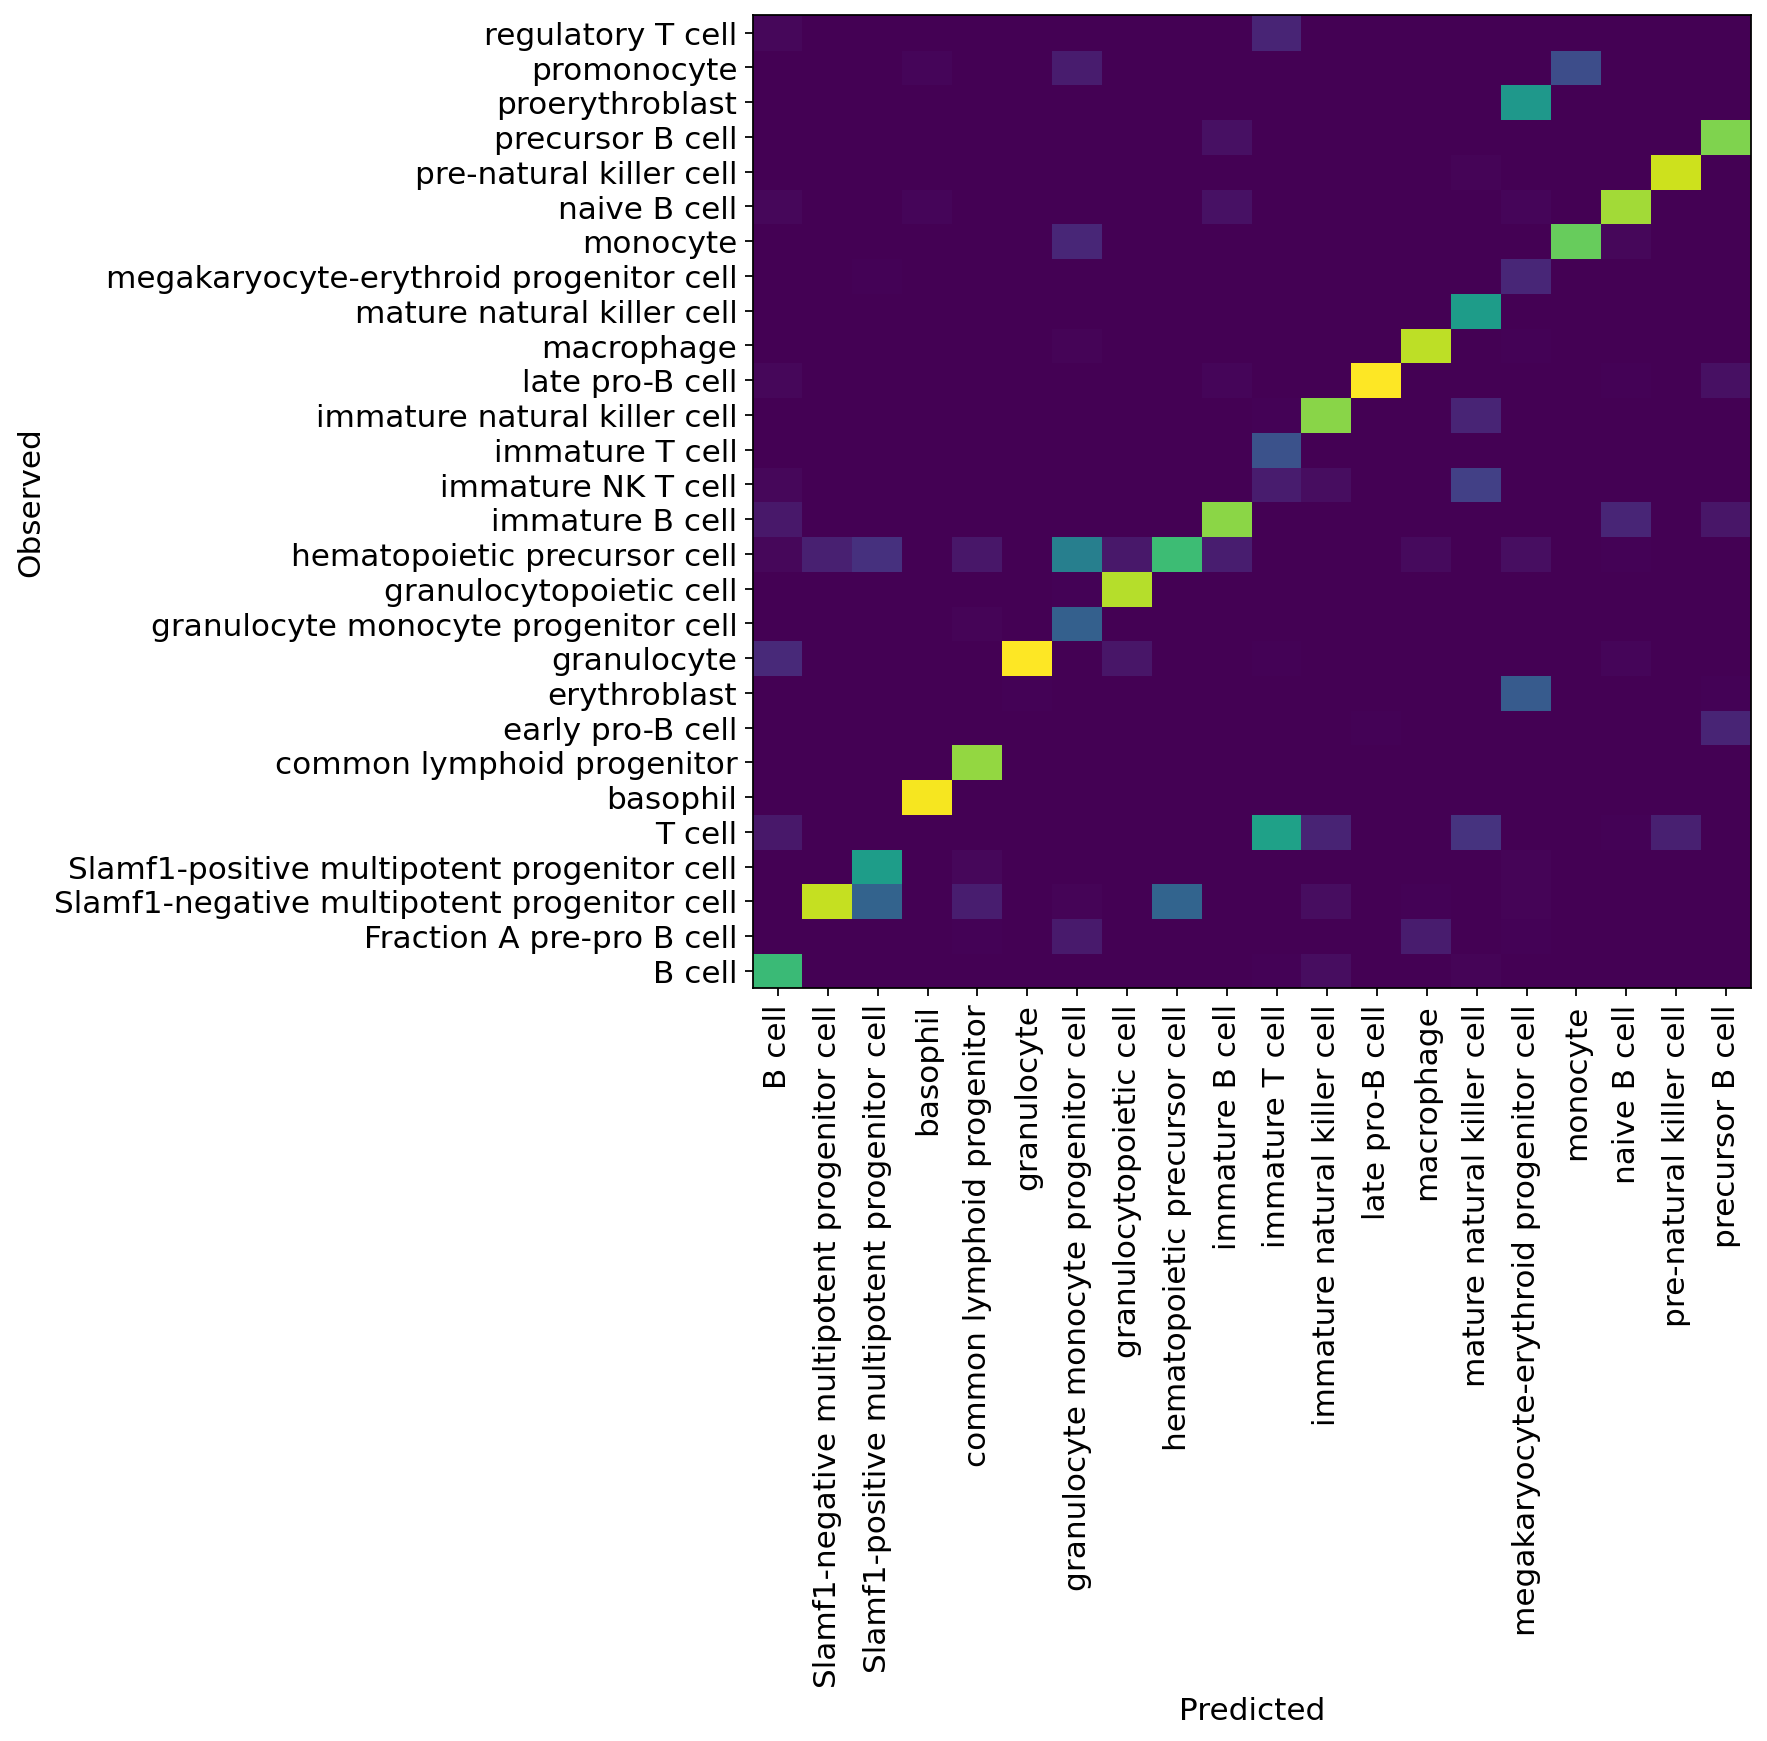

In [ ]:
df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

As we see in this, scANVI's latent space separates all cell types and performs well at classifying major cell types. Since the 10X data is labelled at lower resolution, the transferred labels are not always identical with the original label. However, biologically, the transferred labels are subsets of the original labels. 

Ready to learn more? Dig into our [documentation](https://scvi.readthedocs.io/en/stable/)!